# Preprocess Data

In [1]:
import json
import numpy as np
import cv2
import requests
from PIL import Image
from io import BytesIO
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Layer, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow import keras

def extract_pixels_from_url(url):
    # Download the image using requests
    response = requests.get(url)
    if response.status_code != 200:
        print("Failed to download the image.")
        return None

    # Convert the response content to a Bytes stream
    image_data = BytesIO(response.content)

    # Open the image using PIL
    img = Image.open(image_data)

    # Convert the image to RGB (if it's not already)
    img = img.convert('RGB')

    # Get pixel data
    pixels = list(img.getdata())

    return pixels

In [2]:
data = []

# Open NDJSON file from specified path
with open('/content/drive/MyDrive/Data/export-result4.ndjson', 'r') as f:
    # Read and parse each line (JSON object) in the file
    for line in f:
        # Append parsed JSON object to the 'data' list
        data.append(json.loads(line))

# 'data' now contains all JSON objects from the NDJSON file

In [3]:
processed_data = []

# Iterate through each item in the 'data' list
for item in data:
    # Extract image file name, URL, dimensions, and dataset name
    image_file = item['data_row']['external_id']
    image_url = item['data_row']['row_data']
    image_height = item['media_attributes']['height']
    image_width = item['media_attributes']['width']
    original_dataset = item['data_row']['details']['dataset_name']

    # Initialize lists to store objects and classifications in the image
    objects = []
    classifications = []

    # Check if there are labels (annotations) for the current item
    if item['projects']['clna8cr1l0i0107z19feu8tpt']['labels']:
        # Extract object annotations (like bounding boxes and names)
        for x in item['projects']['clna8cr1l0i0107z19feu8tpt']['labels'][0]['annotations']['objects']:
            objects.append((x['name'], x['bounding_box']))

        # Extract classifications (like radio answers or checklist answers)
        for y in item['projects']['clna8cr1l0i0107z19feu8tpt']['labels'][0]['annotations']['classifications']:
            if 'radio_answer' in y:
                classifications.append((y['name'], y['radio_answer']['name']))
            elif 'checklist_answers' in y:
                for z in y['checklist_answers']:
                    classifications.append((y['name'], z['name']))

    # Append the processed information for each image to 'processed_data'
    processed_data.append({
        'image_file': image_file,
        'image_pixels': extract_pixels_from_url(image_url),
        'image_height': image_height,
        'image_width': image_width,
        'original_dataset': original_dataset,
        'objects': objects,
        'classifications': classifications,
    })


In [4]:
train_damage = []
train_no_damage = []
val = []
test = []

# Split processed data into 4 datasets
for item in processed_data:
    if item['original_dataset'] == 'Test':
        test.append(item)
    elif item['original_dataset'] == 'No Damage':
        train_no_damage.append(item)
    elif item['original_dataset'] == 'Train':
        train_damage.append(item)
    elif item['original_dataset'] == 'Validate':
        val.append(item)

# Exterior Damage Localization

In [5]:
# Dictionary mapping specific parts of a vehicle's exterior to numerical classes.
# This is used for categorizing different areas of a vehicle, such as the front end, sides, rear end, etc.
exterior_location_class_map = {
    "Front End (front bumper, hood, front grille, front fenders, front lights, front windshield)": 1,
    "Sides (doors, side mirrors, side fenders, windows, side skirts, pillars)": 2,
    "Rear end (rear bumper, trunk lid, tailgate, rear lights, rear windshield, rear spoiler)": 3,
    "Roof (roof panel, sunroof, roof rails)": 4,
    "Undercarriage (front and rear axles, exhaust system, chassis/frame)": 5,
    "Wheels and tires (alloy rims, wheel covers, tires)": 6
}

# Dictionary mapping types of damage or conditions found on vehicles to numerical classes.
# Useful for categorizing common vehicle damages like dents, scratches, broken glass, etc.
object_class_map = {
    "Dent": 1,
    "Scratch/Scuff/Chip": 2,
    "Broken Glass": 3,
    "Headlight broken": 4,
    "Taillight broken": 5,
    "Smash": 6,
    "Rust": 7,
    "Puncture": 8
}


In [6]:
def edl_preprocess_data(data_list, image_shape=(1024, 1024, 3), obj_classification_map=object_class_map, ext_classification_map=exterior_location_class_map):
    # Initialize lists to store processed images, bounding boxes, and classes.
    images = []
    boxes = []
    box_classes = []
    classifications = []

    for data in data_list:
        # Reshape image pixel data to the specified image shape.
        image = np.array(data['image_pixels']).reshape(data['image_height'], data['image_width'], 3)
        images.append(image)

        bounding_boxes = []
        ext_location = []
        object_classes = []

        # Process each object annotation in the data.
        for obj, box in data['objects']:
            # Normalize bounding box coordinates and append to list.
            normalized_box = [box['top'] / image_shape[0], box['left'] / image_shape[1],
                              (box['top'] + box['height']) / image_shape[0],
                              (box['left'] + box['width']) / image_shape[1]]
            bounding_boxes.append(normalized_box)
            # Map object names to corresponding classes.
            object_classes.append(obj_classification_map.get(obj, -1))

        # Process each classification in the data.
        for category, value in data['classifications']:
            if category == 'Exterior Location':
                # Map exterior location names to corresponding classes.
                ext_location.append(ext_classification_map.get(value, -1))

        # Append processed data to respective lists.
        boxes.append(np.array(bounding_boxes, dtype=np.float64))
        classifications.append(np.array(ext_location))
        box_classes.append(np.array(object_classes))

    # Return arrays of processed images, bounding boxes, box classes, and classifications.
    return np.array(images), np.array(boxes), np.array(box_classes), np.array(classifications)

def pad_classes(input):
    # Convert input to numpy array and ensure each element is a list.
    my_array = np.array([list(item) for item in np.array(input)])

    # Find maximum length of lists in array.
    max_length = max(len(item) for item in my_array)

    # Pad each list in array to maximum length.
    padded_array = np.array([item + [0] * (max_length - len(item)) for item in my_array])

    return padded_array

def pad_boxes(arrays, pad_value=0):
    # Determine maximum dimensions across all arrays.
    max_rows = max(array.shape[0] for array in arrays)
    max_cols = max(array.shape[1] for array in arrays)

    # Pad each array to the maximum dimensions.
    padded_arrays = []
    for array in arrays:
        padding = ((0, max_rows - array.shape[0]),
                   (0, max_cols - array.shape[1]))
        padded_array = np.pad(array, padding, mode='constant', constant_values=pad_value)
        padded_arrays.append(padded_array)

    return padded_arrays


In [7]:
# Preprocess Testing Data
test_images, test_boxes, test_box_classes, test_ext_classes = edl_preprocess_data(data_list=test)

In [8]:
# Load a pre-trained model from a specified file path.
model = keras.models.load_model('/content/drive/MyDrive/Models/ext_damage_localization_model.keras')

# Convert the test images into a TensorFlow tensor and normalize them.
edl_tensor_test_images = tf.convert_to_tensor(test_images) / 255

# Use the loaded model to make predictions on the preprocessed test images.
predictions = model.predict(edl_tensor_test_images)


1/1 [==============================] - 8s 8s/step


In [9]:
def normalize(value, old_min=-4, old_max=4, new_min=0, new_max=1024):
    # Normalize 'value' from the range [old_min, old_max] to [new_min, new_max].
    return new_min + ((value - old_min) * (new_max - new_min)) / (old_max - old_min)

# Apply the 'normalize' function to each element in 'predictions[2]'.
# This reverses the normalization process to get the original scale of values.
unnormalized_values = [normalize(x) for x in predictions[2]]

# Reshape each array in 'unnormalized_values' to have a shape of (-1, 4).
# Useful for converting flat lists into a specific array shape, e.g., for bounding boxes.
boxes_reshaped = [arr.reshape(-1, 4) for arr in unnormalized_values]


In [10]:
# Extract the most likely class number for each prediction in 'predictions[0]' and 'predictions[1]'.
box_class_predictions_nums = np.argmax(predictions[0], axis=-1)
ext_class_predictions_nums = np.argmax(predictions[1], axis=-1)

# Create inverse mappings from class numbers back to class names for both object and exterior location classes.
inverted_object_class_map = {v: k for k, v in object_class_map.items()}
inverted_exterior_location_class_map = {v: k for k, v in exterior_location_class_map.items()}

# Function to get the object class name from a class number.
def get_object_class_name(class_number):
    return inverted_object_class_map.get(class_number, "Unknown")

# Function to get the exterior location class name from a class number.
def get_exterior_location_class_name(class_number):
    return inverted_exterior_location_class_map.get(class_number, "Unknown")

# Convert numerical class predictions for box classes and exterior classes to their corresponding names.
box_class_predictions = [get_object_class_name(x) for x in box_class_predictions_nums]
ext_class_predictions = [get_exterior_location_class_name(x) for x in ext_class_predictions_nums]


# Exterior Damage Severity Assessment

In [11]:
# Define class map for severity
severity_class_map = {
    'No Damage': 0,
    'Minor Damage': 1,
    'Moderate Damage': 2,
    'Major Damage': 3,
    'Totaled': 4
}

In [12]:
def preprocess_data(data_list, image_shape=(1024, 1024, 3), severity_classification_map=severity_class_map):
    # Initialize lists to hold processed images and their classifications.
    images = []
    classifications = []

    # Loop through each item in the provided dataset.
    for data in data_list:
        # Convert and reshape image pixel data to the specified image shape.
        image = np.array(data['image_pixels']).reshape(data['image_height'], data['image_width'], 3)
        images.append(image)  # Add processed image to the list.

        ext_severity = []  # List to store severity classifications.

        # Iterate through classifications in the data.
        for classification, value in data['classifications']:
            # Check for 'Exterior Damage Severity' classification and map its value.
            if classification == 'Exterior Damage Severity':
                # Map severity values using the provided classification map.
                ext_severity.append(severity_class_map.get(value, 0))

        # Append processed severity classifications to the classifications list.
        classifications.append(np.array(ext_severity))

    # Return the processed images and classifications as numpy arrays.
    return np.array(images), np.array(classifications)


In [13]:
# Preprocess the training and testing data to extract images and exterior severity classes.
train_images, train_ext_sev_classes = preprocess_data(data_list=train_damage)
test_images, test_ext_sev_classes = preprocess_data(data_list=test)

# Convert the training images into a TensorFlow tensor and normalize pixel values to [0, 1] range.
tensor_train_images = tf.convert_to_tensor(train_images) / 255

# Convert the test images into a TensorFlow tensor and normalize pixel values to [0, 1] range.
tensor_test_images = tf.convert_to_tensor(test_images) / 255

# Convert the training exterior severity classes into a TensorFlow tensor.
tensor_train_ext_sev_classes = tf.convert_to_tensor(train_ext_sev_classes)


In [14]:
# Load Model
ext_severity_model = keras.models.load_model('/content/drive/MyDrive/Models/ext_damage_severity_model.keras')

In [15]:
# Perform predictions
predictions = ext_severity_model.predict(tensor_test_images)

1/1 [==============================] - 0s 240ms/step


In [16]:
# Identify the most likely class number for each prediction using the argmax function.
ext_sev_class_predictions_nums = np.argmax(predictions, axis=-1)

# Create an inverse mapping from class numbers back to class names for exterior severity classes.
inverted_exterior_sev_class_map = {v: k for k, v in severity_class_map.items()}

# Define a function to translate a class number into its corresponding class name.
def get_exterior_sev_class_name(class_number):
    return inverted_exterior_sev_class_map.get(class_number, "Unknown")

# Convert the array of class numbers into an array of class names using the mapping.
ext_sev_class_predictions = [get_exterior_sev_class_name(x) for x in ext_sev_class_predictions_nums]


# Interior Damage Localization and Severity Assessment

In [17]:
# Define class maps for severity, exterior location, and interior regions affected
int_sev_class_map = {
    'No Damage': 0,
    'Minor Damage': 1,
    'Moderate Damage': 2,
    'Major Damage': 3,
    'Totaled': 4
}

interior_regions_class_map = {
    'Dashboard Area (Instrument panel, center console, globe compartment)': 1,
    'Front Area (driver\'s seat, passenger seat, gear shift, pedals, steering wheel and column, footwells)': 2,
    'Middle Area (rear seats, center armrest, floor console)': 3,
    'Storage and Utility (door pockets, cup holders, rear parcel shelf, boot/trunk)': 4,
    'Roof Area ( sun visors, rearview mirror, sunroof, roof lining, grab handles)': 5,
    'Rear area (backseat pockets, rear air vents, rear center console)': 6,
    'Miscellaneous (lighting, ports and outlets, controls)': 7,
    'Engine compartment (engine, radiator, battery, air filter, fuse box)': 8,
    'Transmission and Drivetrain (transmission, drive shaft, differential, axles)': 9,
    'Exhaust system (exhaust manifold, catalytic converter, muffler, exhaust pipe)': 10,
    'Fuel System (fuel tank, fuel pump, fuel injectors)': 11,
    'Brake system (brake pedal, master cylinder, brake pads, rotors, brake calipers)': 12,
    'Suspension and steering (shock absorbers/struts, springs, control arms, steering rack and pinion)': 13,
    'electrical system (alternator, starter motor, wiring harness)': 14,
    'climate system (air conditioning compressor, heater core, blower motor)': 15,
    'Body and frame (chasis, frame, body panels)': 16
}

In [18]:
def preprocess_data(data_list, image_shape=(1024, 1024, 3), int_sev_map=int_sev_class_map, int_classification_map=interior_regions_class_map):
    # Initialize lists to store processed images, severity classes, and classifications.
    images = []
    sev_classes = []
    classifications = []

    # Iterate over each data entry in the provided list.
    for data in data_list:
        # Convert image pixel data to a numpy array and reshape it.
        image = np.array(data['image_pixels']).reshape(data['image_height'], data['image_width'], 3)
        images.append(image)  # Add the processed image to the list.

        # Initialize lists for interior severity and location classifications.
        int_sev = []
        int_location = []

        # Process and map each classification to its corresponding integer value.
        for category, value in data['classifications']:
            # Map interior locations.
            if category == 'Potential Interior Regions Affected':
                int_location.append(int_classification_map.get(value, -1))

            # Map interior severity.
            if category == 'Interior Damage Severity':
                int_sev.append(int_sev_map.get(value, 0))

        # Append the processed classifications to the respective lists.
        classifications.append(np.array(int_location))
        sev_classes.append(np.array(int_sev))

    # Return the processed data as numpy arrays.
    return np.array(images), np.array(sev_classes), np.array(classifications)

def pad_classes(input):
    # Convert input to a numpy array, ensuring each element is a list.
    my_array = np.array([list(item) for item in np.array(input)])

    # Determine the maximum length among the lists.
    max_length = max(len(item) for item in my_array)

    # Pad each list in the array to the maximum length with zeros.
    padded_array = np.array([item + [0] * (max_length - len(item)) for item in my_array])

    return padded_array


In [19]:
# Preprocess the training and test datasets to extract images, interior severity classes, and locations.
train_images, train_int_sev_classes, train_int_locations = preprocess_data(data_list=train_damage)
test_images, test_int_sev_classes, test_int_locations = preprocess_data(data_list=test)

# Pad the interior location data for the training set to ensure uniform tensor sizes.
padded_train_int_locations = pad_classes(train_int_locations)

# Convert the training and test images into TensorFlow tensors and normalize their pixel values.
tensor_train_images = tf.convert_to_tensor(train_images) / 255
tensor_test_images = tf.convert_to_tensor(test_images) / 255

# Convert the training interior severity classes to one-hot encoded format.
train_int_sev_classes_one_hot = to_categorical(train_int_sev_classes, num_classes=5)

# Convert the padded training interior location classes to a TensorFlow tensor.
tensor_train_int_classes = tf.convert_to_tensor(padded_train_int_locations)


<ipython-input-18-2260fd853edb>:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(images), np.array(sev_classes), np.array(classifications)
<ipython-input-18-2260fd853edb>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  my_array = np.array([list(item) for item in np.array(input)])


In [20]:
def transform_to_binary_matrix(labels, num_classes=16):
    # Initialize a zero matrix with dimensions based on the number of labels and classes.
    binary_matrix = np.zeros((len(labels), num_classes))

    # Iterate over each label set and its index.
    for i, label_set in enumerate(labels):
        # Iterate through each label in the set.
        for label in label_set:
            # Check if the label is greater than 0 (assuming 0 means 'no class').
            if label > 0:
                # Set the corresponding position in the matrix to 1.
                # Adjust index by subtracting 1 because classes are 1-indexed.
                binary_matrix[i, label - 1] = 1

    # Return the binary matrix representing the label data.
    return binary_matrix

# Convert the training and test interior location labels into binary matrices.
train_int_locations_binary = transform_to_binary_matrix(train_int_locations)
test_int_locations_binary = transform_to_binary_matrix(test_int_locations)


In [21]:
# Load Model
model = keras.models.load_model('/content/drive/MyDrive/Models/int_damage_and_severity_model.keras')

In [22]:
# Generate Predictions
predictions = model.predict(tensor_test_images)

1/1 [==============================] - 0s 362ms/step


In [23]:
# Use argmax to find the most likely class number for each prediction in two sets of predictions.
int_sev_class_predictions_nums = np.argmax(predictions[0], axis=-1)
int_class_predictions_nums = np.argmax(predictions[1], axis=-1)

# Create inverse mappings from class numbers back to class names for both severity and interior location classes.
inverted_int_sev_class_map = {v: k for k, v in int_sev_class_map.items()}
inverted_interior_location_class_map = {v: k for k, v in interior_regions_class_map.items()}

# Define functions to retrieve the class name for a given class number using the inverse maps.
def get_int_sev_class_name(class_number):
    return inverted_int_sev_class_map.get(class_number, "Unknown")

def get_interior_location_class_name(class_number):
    return inverted_interior_location_class_map.get(class_number, "Unknown")

# Convert arrays of class numbers to arrays of class names for both severity and interior classes.
sev_class_predictions = [get_int_sev_class_name(x) for x in int_sev_class_predictions_nums]
int_class_predictions = [get_interior_location_class_name(x) for x in int_class_predictions_nums]


# Total Cost Estimation

In [24]:
def calculate_repair_cost(exterior_location, exterior_damage, exterior_severity, interior_severity, interior_location):
    """
    Calculate the total repair cost based on the given parameters and the defined mappings.

    :param exterior_location: String representing the location of the exterior damage
    :param exterior_damage: String representing the type of exterior damage
    :param exterior_severity: String representing the severity of the exterior damage
    :param interior_severity: String representing the severity of the interior damage
    :param interior_location: String representing the location of the interior damage
    :return: Total repair cost as an integer
    """
    # Define the mappings
    exterior_location_class_map_cost = {
        "Front End (front bumper, hood, front grille, front fenders, front lights, front windshield)": 300,
        "Sides (doors, side mirrors, side fenders, windows, side skirts, pillars)": 200,
        "Rear end (rear bumper, trunk lid, tailgate, rear lights, rear windshield, rear spoiler)": 150,
        "Roof (roof panel, sunroof, roof rails)": 300,
        "Undercarriage (front and rear axles, exhaust system, chassis/frame)": 200,
        "Wheels and tires (alloy rims, wheel covers, tires)": 100,
        "Unknown": 0
    }

    exterior_damage_class_map_cost = {
        "Dent": 200,
        "Scratch/Scuff/Chip": 300,
        "Broken Glass": 100,
        "Headlight broken": 100,
        "Taillight broken": 100,
        "Smash": 300,
        "Rust": 300,
        "Puncture": 150,
        "Unknown": 0
    }

    exterior_severity_class_map_cost = {
        'No Damage': 0,
        'Minor Damage': 1,
        'Moderate Damage': 1.5,
        'Major Damage': 2,
        'Totaled': 3,
        "Unknown": 0
    }

    interior_severity_class_map_cost = {
        'No Damage': 0,
        'Minor Damage': 1,
        'Moderate Damage': 1.5,
        'Major Damage': 2,
        'Totaled': 3,
        "Unknown": 0
    }

    interior_location_class_map_cost = {
        'Dashboard Area (Instrument panel, center console, globe compartment)': 1000,
        'Front Area (driver\'s seat, passenger seat, gear shift, pedals, steering wheel and column, footwells)': 200,
        'Middle Area (rear seats, center armrest, floor console)': 125,
        'Storage and Utility (door pockets, cup holders, rear parcel shelf, boot/trunk)': 200,
        'Roof Area (sun visors, rearview mirror, sunroof, roof lining, grab handles)': 900,
        'Rear area (backseat pockets, rear air vents, rear center console)': 550,
        'Miscellaneous (lighting, ports and outlets, controls)': 370,
        'Engine compartment (engine, radiator, battery, air filter, fuse box)': 3100,
        'Transmission and Drivetrain (transmission, drive shaft, differential, axles)': 1200,
        'Exhaust system (exhaust manifold, catalytic converter, muffler, exhaust pipe)': 1150,
        'Fuel System (fuel tank, fuel pump, fuel injectors)': 950,
        'Brake system (brake pedal, master cylinder, brake pads, rotors, brake calipers)': 900,
        'Suspension and steering (shock absorbers/struts, springs, control arms, steering rack and pinion)': 2000,
        'electrical system (alternator, starter motor, wiring harness)': 1000,
        'climate system (air conditioning compressor, heater core, blower motor)': 1300,
        'Body and frame (chasis, frame, body panels)': 600,
        "Unknown": 0
    }

    # Calculate the costs
    exterior_location_cost = exterior_location_class_map_cost.get(exterior_location, 0)
    exterior_damage_cost = exterior_damage_class_map_cost.get(exterior_damage, 0)
    exterior_severity_multiplier = exterior_severity_class_map_cost.get(exterior_severity, 0)
    interior_severity_multiplier = interior_severity_class_map_cost.get(interior_severity, 0)
    interior_location_cost = interior_location_class_map_cost.get(interior_location, 0)

    # Calculate total cost
    total_cost = (exterior_location_cost + exterior_damage_cost) * exterior_severity_multiplier
    total_cost += interior_location_cost * interior_severity_multiplier

    int_cost = interior_location_cost * interior_severity_multiplier
    ext_cost = (exterior_location_cost + exterior_damage_cost) * exterior_severity_multiplier

    return total_cost, int_cost, ext_cost





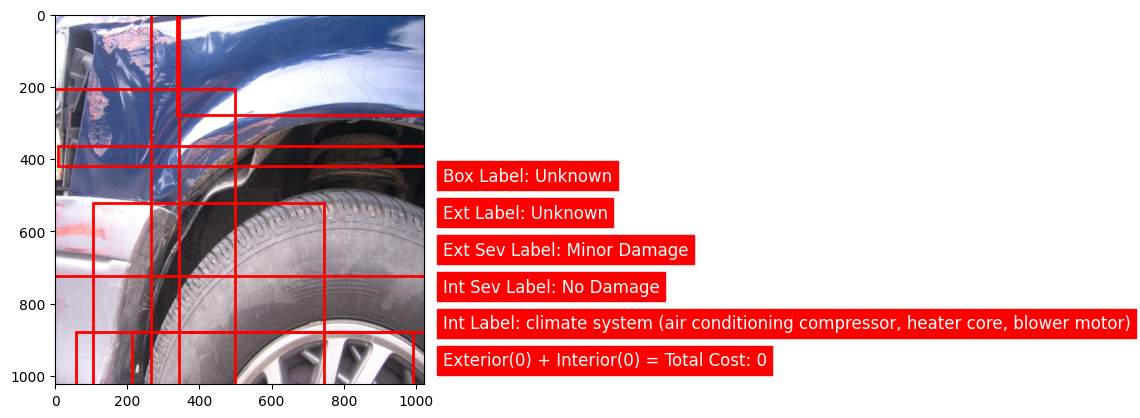

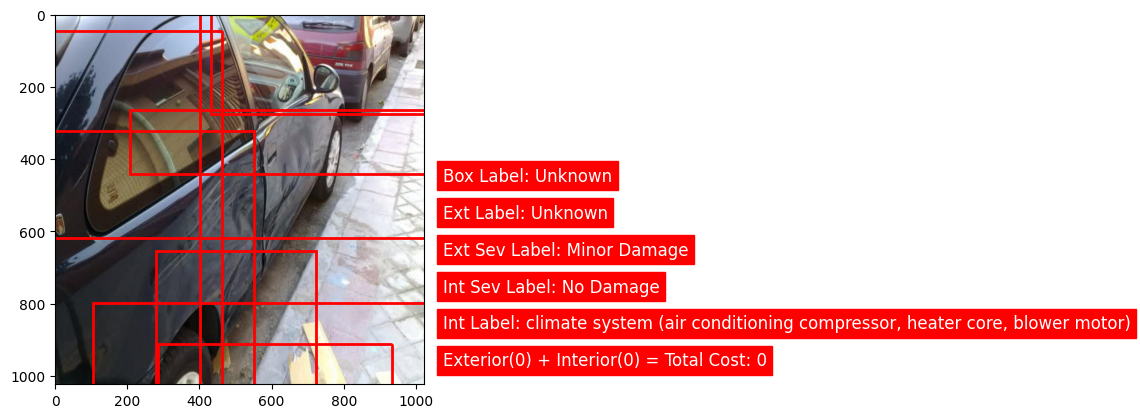

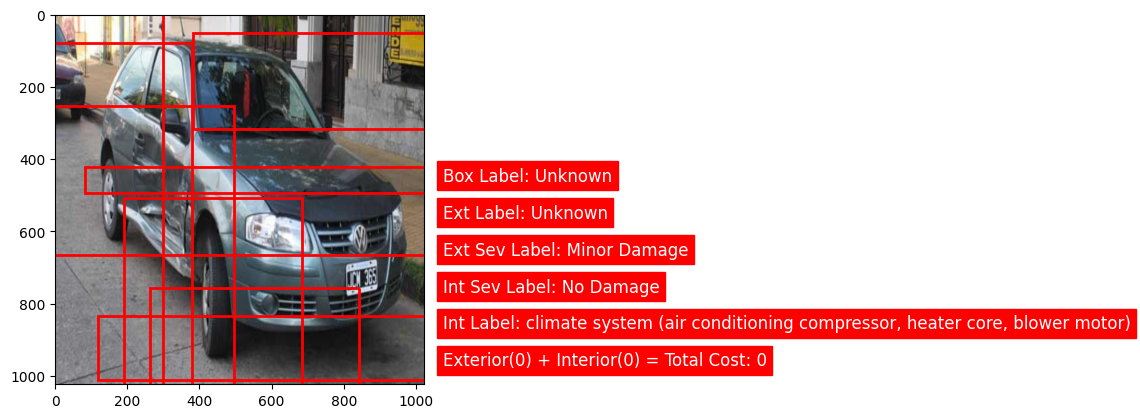

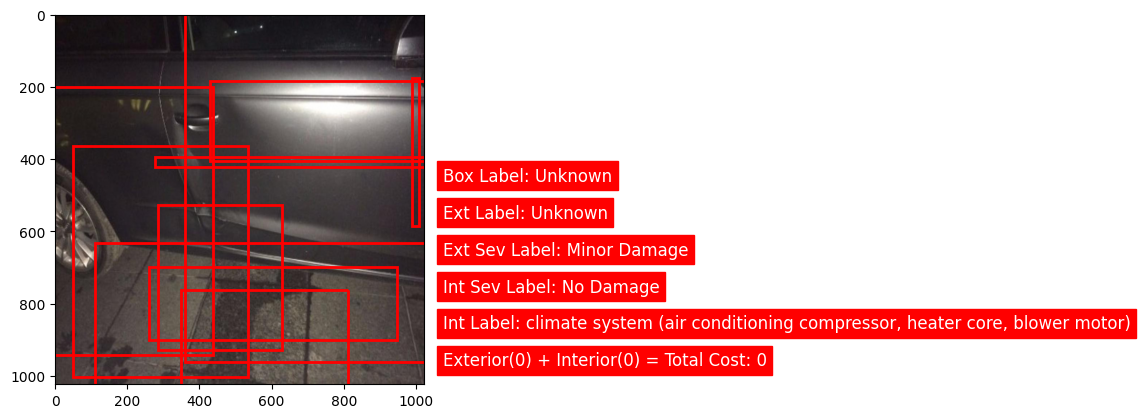

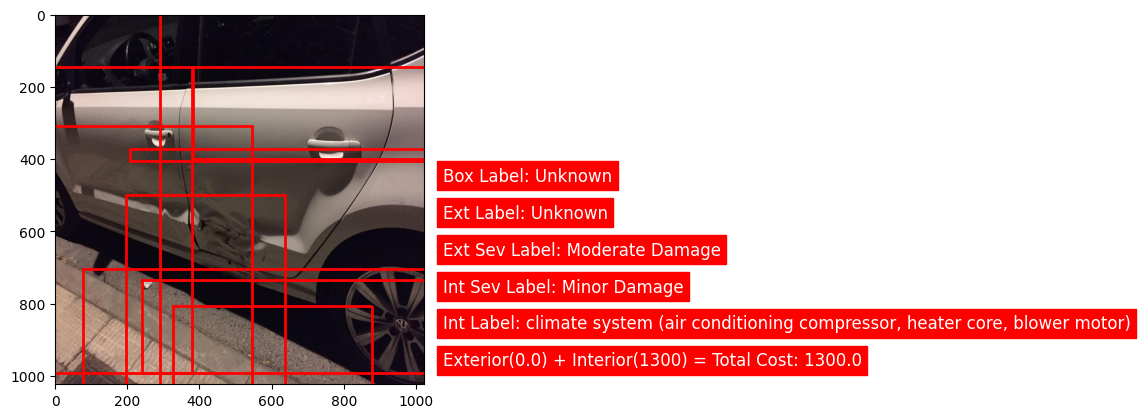

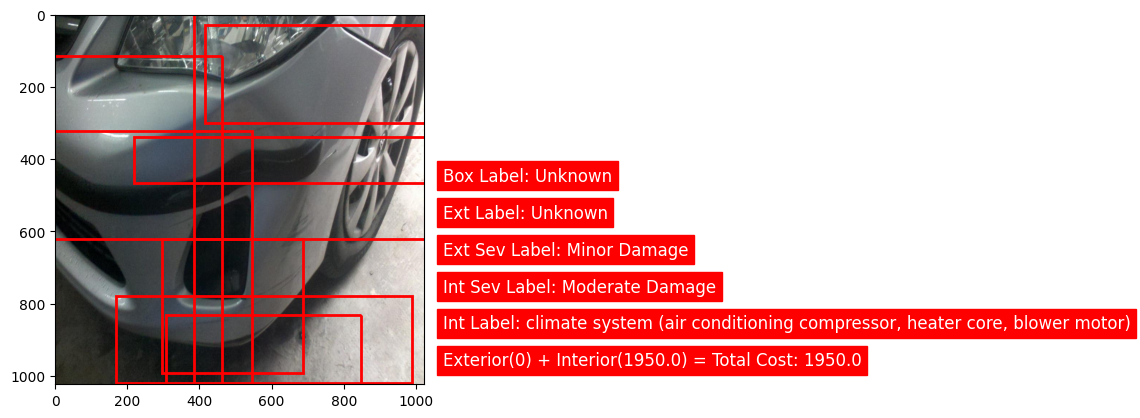

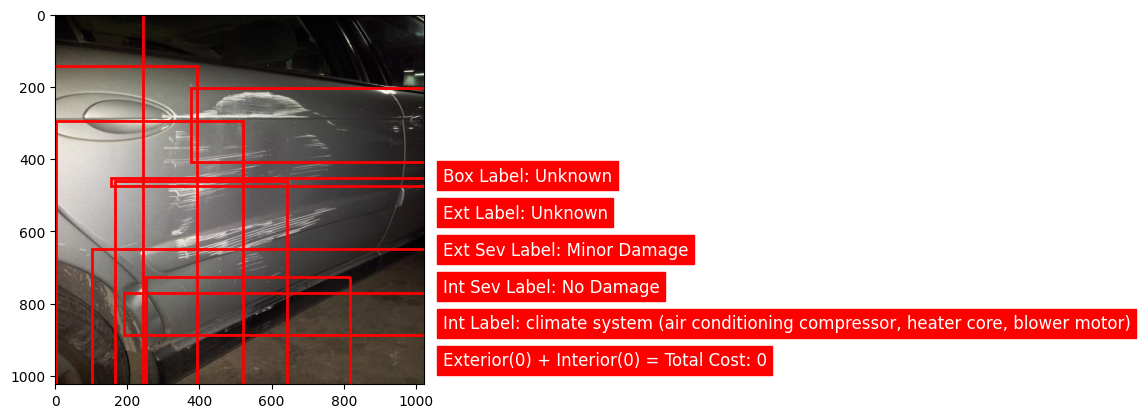

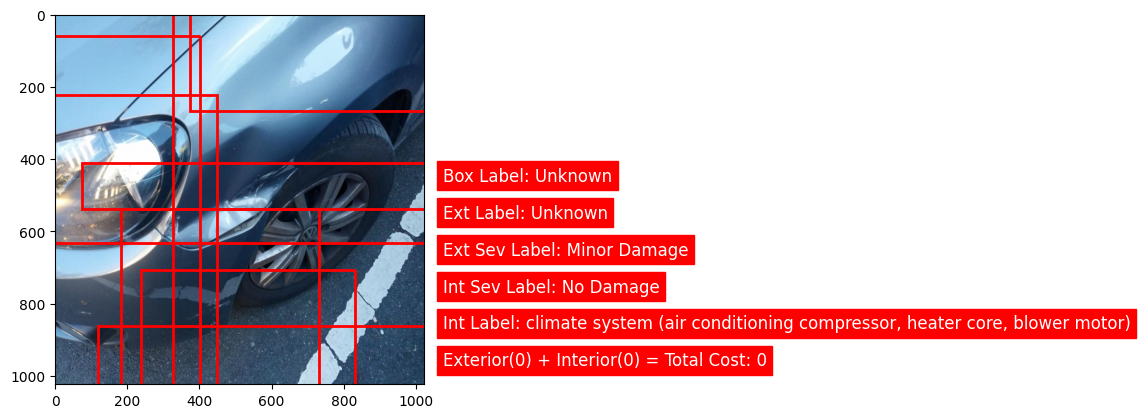

In [25]:
# Loop through each test image.
for x in range(len(edl_tensor_test_images)):
    # Extract relevant information for the current image.
    image_array = edl_tensor_test_images[x]
    bounding_boxes = boxes_reshaped[x]
    box_labels = box_class_predictions[x]  # Box label predictions for the current image.
    ext_labels = ext_class_predictions[x]  # Exterior label predictions for the current image.
    ext_sev_labels = ext_sev_class_predictions[x]  # Exterior severity label predictions.
    int_sev_labels = sev_class_predictions[x]  # Interior severity label predictions.
    int_labels = int_class_predictions[x]  # Interior label predictions.

    # Calculate the repair cost based on the predicted labels.
    total_cost, int_cost, ext_cost = calculate_repair_cost(ext_labels, box_labels, ext_sev_labels, int_sev_labels, int_labels)

    # Create a plot for the image.
    fig, ax = plt.subplots(1)
    ax.imshow(image_array)

    # Draw bounding boxes on the image.
    for box in bounding_boxes:
        # Convert the normalized box coordinates to pixel coordinates.
        y_min, x_min, y_max, x_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Display the predicted labels and repair cost information on the image.
    plt.text(1.05, 0.55, "Box Label: " + str(box_labels), color='white', fontsize=12, backgroundcolor='red', transform=ax.transAxes)
    plt.text(1.05, 0.45, "Ext Label: " + str(ext_labels), color='white', fontsize=12, backgroundcolor='red', transform=ax.transAxes)
    plt.text(1.05, 0.35, "Ext Sev Label: " + str(ext_sev_labels), color='white', fontsize=12, backgroundcolor='red', transform=ax.transAxes)
    plt.text(1.05, 0.25, "Int Sev Label: " + str(int_sev_labels), color='white', fontsize=12, backgroundcolor='red', transform=ax.transAxes)
    plt.text(1.05, 0.15, "Int Label: " + str(int_labels), color='white', fontsize=12, backgroundcolor='red', transform=ax.transAxes)
    plt.text(1.05, 0.05, "Exterior(" + str(ext_cost) + ") + Interior(" + str(int_cost) + ") = Total Cost: " + str(total_cost), color='white', fontsize=12, backgroundcolor='red', transform=ax.transAxes)

# Show the plotted images with annotations.
plt.show()
